In [1]:
using Turing
using DataFrames
using CSV
using Random
using Distributions
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using StatsPlots
using StatsBase
using Logging
using LinearAlgebra

default(label=false);
Logging.disable_logging(Logging.Warn);

# 14.1 Varying slopes by construction

Code 14.1

In [2]:
a = 3.5    # average morning wait time
b = -1     # average difference afternoon wait time
σ_a = 1    # std dev in intercepts
σ_b = 0.5  # std dev in slopes
ρ = -0.7;  # correlation between intercepts and slopes

Code 14.2

In [3]:
μ = [a, b];

Code 14.3

In [4]:
cov_ab = σ_a * σ_b * ρ
Σ = [[σ_a^2, cov_ab] [cov_ab, σ_b^2]]

2×2 Matrix{Float64}:
  1.0   -0.35
 -0.35   0.25

Code 14.4

Julia has similar "column-first" matix order

In [5]:
reshape(1:4, (2,2))

2×2 reshape(::UnitRange{Int64}, 2, 2) with eltype Int64:
 1  3
 2  4

Code 14.5

In [6]:
sigmas = [σ_a, σ_b]
Ρ = [[1, ρ] [ρ, 1]]
Σ = Diagonal(sigmas) * Ρ * Diagonal(sigmas);

Code 14.6

In [7]:
N_cafes = 20;

Code 14.7

In [8]:
Random.seed!(5)
vary_effect = rand(MvNormal(μ, Σ), N_cafes);

Code 14.8

In [9]:
a_cafe = vary_effect[1,:]
b_cafe = vary_effect[2,:];

Code 14.9

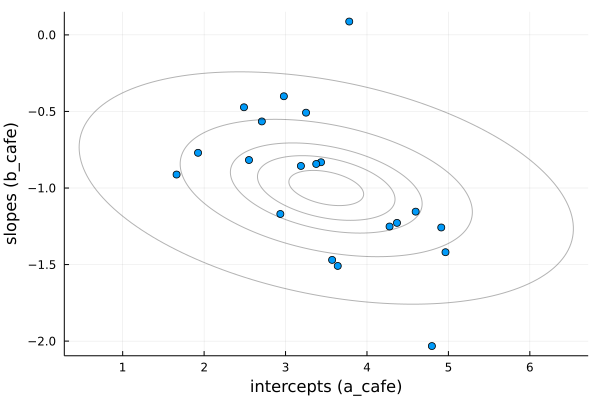

In [10]:
p = scatter(a_cafe, b_cafe, xlab="intercepts (a_cafe)", ylab="slopes (b_cafe)")

d = acos(Σ[1,2])
chi = Chisq(2)

for l ∈ (0.1, 0.3, 0.5, 0.8, 0.99)
    scale = sqrt(quantile(chi, l))
    xₜ(t) = scale*Σ[1,1]*cos(t + d/2) + μ[1]
    yₜ(t) = scale*Σ[2,2]*cos(t - d/2) + μ[2]

    plot!(xₜ, yₜ, 0, 2π, c=:black, alpha=0.3)
end
p

Code 14.10

In [11]:
Random.seed!(1)
N_visits = 10

afternoon = repeat(0:1, N_visits*N_cafes ÷ 2)
cafe_id = repeat(1:N_cafes, inner=N_visits)
μ = a_cafe[cafe_id] + b_cafe[cafe_id] .* afternoon
σ = 0.5
wait = rand.(Normal.(μ, σ))
d = DataFrame(cafe=cafe_id, afternoon=afternoon, wait=wait);

Code 14.11

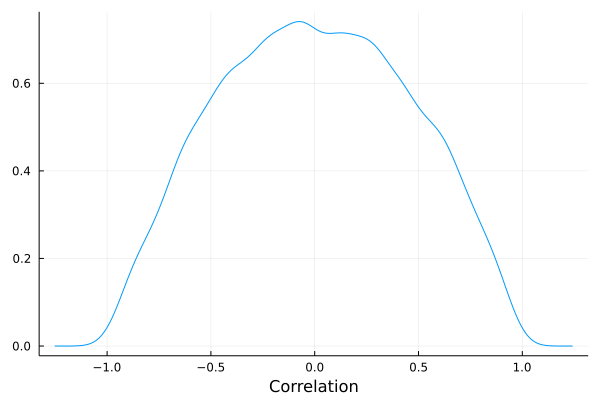

In [12]:
R = rand(LKJ(2, 2), 10^4);
density(getindex.(R, 2), xlab="Correlation")

Code 14.12

In [13]:
@model function m14_1(cafe, afternoon, wait)
    a ~ Normal(5, 2)
    b ~ Normal(-1, 0.5)
    σ_cafe ~ filldist(Exponential(), 2)
    Rho ~ LKJ(2, 2)
    # build sigma matrix manually, to avoid numerical errors
#     (σ₁, σ₂) = σ_cafe
#     sc = [[σ₁^2, σ₁*σ₂] [σ₁*σ₂, σ₂^2]]
#     Σ = Rho .* sc
    # the same as above, but shorter and generic
    Σ = (σ_cafe .* σ_cafe') .* Rho
    ab ~ filldist(MvNormal([a,b], Σ), N_cafes)
    a = ab[1,cafe]
    b = ab[2,cafe]
    μ = @. a + b * afternoon
    σ ~ Exponential()
    for i ∈ eachindex(wait)
        wait[i] ~ Normal(μ[i], σ)
    end
end

Random.seed!(1)
m14_1_ch = sample(m14_1(d.cafe, d.afternoon, d.wait), NUTS(), 1000)
m14_1_df = DataFrame(m14_1_ch);

Code 14.13

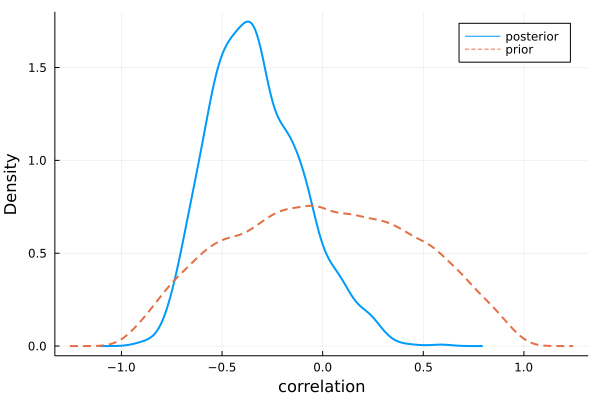

In [14]:
density(m14_1_df."Rho[1,2]", lab="posterior", lw=2)

R = rand(LKJ(2, 2), 10^4);
density!(getindex.(R, 2), lab="prior", ls=:dash, lw=2)
plot!(xlab="correlation", ylab="Density")

Code 14.14

Plot differs from presented in the book due to different seed in data generation.

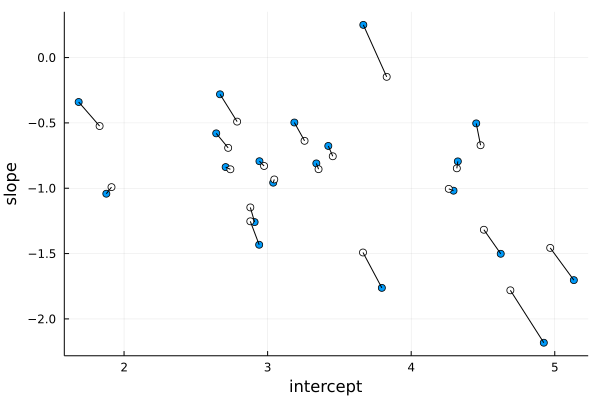

In [15]:
gb = groupby(d[d.afternoon .== 0,:], :cafe)
a1 = combine(gb, :wait => mean).wait_mean

gb = groupby(d[d.afternoon .== 1,:], :cafe)
b1 = combine(gb, :wait => mean).wait_mean .- a1

a2 = [mean(m14_1_df[:, "ab[1,$i]"]) for i ∈ 1:N_cafes]
b2 = [mean(m14_1_df[:, "ab[2,$i]"]) for i ∈ 1:N_cafes]

xlim = extrema(a1) .+ (-0.1, 0.1)
ylim = extrema(b1) .+ (-0.1, 0.1)

p = scatter(a1, b1, xlab="intercept", ylab="slope", xlim=xlim, ylim=ylim)

scatter!(a2, b2, mc=:white)

for (x1,y1,x2,y2) ∈ zip(a1, b1, a2, b2)
    plot!([x1,x2], [y1,y2], c=:black)
end
p

Code 14.15

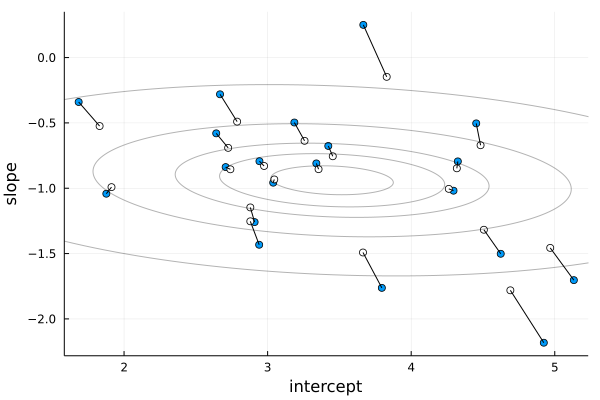

In [16]:
# posterior mean
ρ = mean(m14_1_df."Rho[1,2]")
μ_a = mean(m14_1_df.a)
μ_b = mean(m14_1_df.b)
σ₁ = mean(m14_1_df."σ_cafe[1]")
σ₂ = mean(m14_1_df."σ_cafe[2]")

# draw ellipses
dt = acos(ρ*σ₁*σ₂)
chi = Chisq(2)

for l ∈ (0.1, 0.3, 0.5, 0.8, 0.99)
    scale = sqrt(quantile(chi, l))
    xₜ(t) = scale*σ₁^2*cos(t + dt/2) + μ_a
    yₜ(t) = scale*σ₂^2*cos(t - dt/2) + μ_b

    plot!(xₜ, yₜ, 0, 2π, c=:black, alpha=0.3)
end

p

Code 14.16

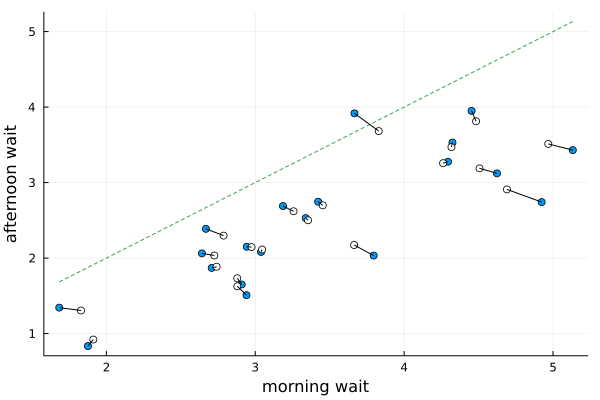

In [17]:
wait_morning_1 = a1
wait_afternoon_1 = a1 .+ b1
wait_morning_2 = a2
wait_afternoon_2 = a2 .+ b2

p = scatter(wait_morning_1, wait_afternoon_1, xlab="morning wait", ylab="afternoon wait")
scatter!(wait_morning_2, wait_afternoon_2, mc=:white)

plot!(x -> x, s=:dash)

for (x1,y1,x2,y2) ∈ zip(wait_morning_1, wait_afternoon_1, wait_morning_2, wait_afternoon_2)
    plot!([x1,x2], [y1,y2], c=:black)
end
p

Code 14.17

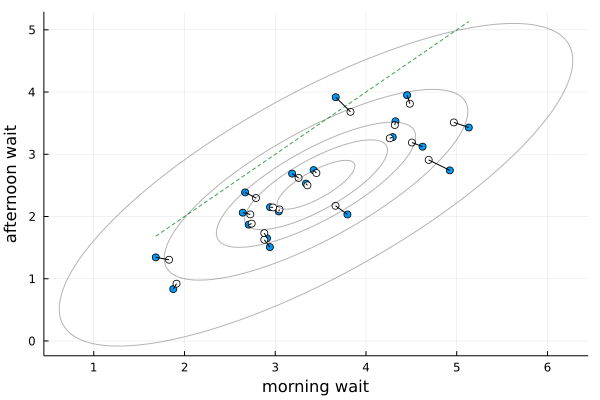

In [18]:
Random.seed!(1)

Σ = [[σ₁^2, σ₁*σ₂*ρ] [σ₁*σ₂*ρ, σ₂^2]]
μ = [μ_a, μ_b]
v = rand(MvNormal(μ, Σ), 10^4)
v[2,:] += v[1,:]
Σ₂ = cov(v')
μ₂ = [μ_a, μ_a+μ_b]

# draw ellipses
dt = acos(Σ₂[1,2])
chi = Chisq(2)

for l ∈ (0.1, 0.3, 0.5, 0.8, 0.99)
    scale = sqrt(quantile(chi, l))
    xₜ(t) = scale*Σ₂[1,1]*cos(t + dt/2) + μ₂[1]
    yₜ(t) = scale*Σ₂[2,2]*cos(t - dt/2) + μ₂[2]

    plot!(xₜ, yₜ, 0, 2π, c=:black, alpha=0.3)
end

p

# 14.2 Advanced varying slopes

Code 14.18

In [19]:
d = DataFrame(CSV.File("data/chimpanzees.csv", delim=';'));
d.treatment = 1 .+ d.prosoc_left .+ 2*d.condition;
d.block_id = d.block;

Random.seed!(123)

@model function m14_2(L, tid, actor, block_id)
    tid_len = length(levels(tid))
    act_len = length(levels(actor))
    blk_len = length(levels(block_id))
    g ~ filldist(Normal(), tid_len)

    σ_actor ~ filldist(Exponential(), tid_len)
    ρ_actor ~ LKJ(tid_len, 2)
    Σ_actor = (σ_actor .* σ_actor') .* ρ_actor
    alpha ~ filldist(MvNormal(zeros(tid_len), Σ_actor), act_len)

    σ_block ~ filldist(Exponential(), tid_len)
    ρ_block ~ LKJ(tid_len, 2)
    Σ_block = (σ_block .* σ_block') .* ρ_block
    beta ~ filldist(MvNormal(zeros(tid_len), Σ_block), blk_len)
    
    for i ∈ eachindex(L)
        p = logistic(g[tid[i]] + alpha[tid[i], actor[i]] + beta[tid[i], block_id[i]])
        L[i] ~ Bernoulli(p)
    end
end


m14_2_ch = sample(m14_2(d.pulled_left, d.treatment, d.actor, d.block_id), HMC(0.01, 10), 1000);
m14_2_df = DataFrame(m14_2_ch);

Code 14.19

In [20]:
@model function m14_3(L, tid, actor, block_id)
    tid_len = length(levels(tid))
    act_len = length(levels(actor))
    blk_len = length(levels(block_id))
    g ~ filldist(Normal(), tid_len)

    σ_actor ~ filldist(Exponential(), tid_len)
    # LKJCholesky is not usable in Turing: https://github.com/TuringLang/Turing.jl/issues/1629
    ρ_actor ~ LKJ(tid_len, 2)    
    ρ_actor_L = cholesky(Symmetric(ρ_actor)).L
    z_actor ~ filldist(MvNormal(zeros(tid_len), 1), act_len)
    alpha = (σ_actor .* ρ_actor_L) * z_actor

    σ_block ~ filldist(Exponential(), tid_len)
    ρ_block ~ LKJ(tid_len, 2)
    ρ_block_L = cholesky(Symmetric(ρ_block)).L        
    z_block ~ filldist(MvNormal(zeros(tid_len), 1), blk_len)
    beta = (σ_block .* ρ_block_L) * z_block

    for i ∈ eachindex(L)
        p = logistic(g[tid[i]] + alpha[tid[i], actor[i]] + beta[tid[i], block_id[i]])
        L[i] ~ Bernoulli(p)
    end
end

# Hm, this is less stable and slower than m14_2...
# So if you know how to improve it - PR or open the issue in the repo
Random.seed!(123)

m14_3_ch = sample(m14_3(d.pulled_left, d.treatment, d.actor, d.block_id), 
    HMC(0.01, 10), 1000);

Code 14.20

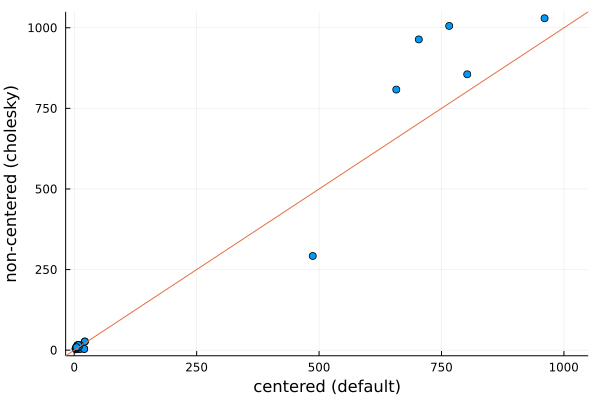

In [21]:
t = DataFrame(ess_rhat(m14_2_ch));
ess_2 = t.ess[occursin.(r"σ|ρ", string.(t.parameters))]
ess_2 = filter(v -> !isnan(v), ess_2);
t = DataFrame(ess_rhat(m14_3_ch));
ess_3 = t.ess[occursin.(r"σ|ρ", string.(t.parameters))]
ess_3 = filter(v -> !isnan(v), ess_3);

bounds = extrema([ess_2; ess_3]) .+ (-20, 20)
scatter(ess_2, ess_3, xlim=bounds, ylim=bounds, xlab="centered (default)", ylab="non-centered (cholesky)")
plot!(identity)

Code 14.21

In [22]:
m14_3_df = DataFrame(m14_3_ch);
precis(m14_3_df[:,r"σ"])

┌────────────┬───────────────────────────────────────────────────────┐
│      param │   mean     std    5.5%     50%   94.5%      histogram │
├────────────┼───────────────────────────────────────────────────────┤
│ σ_actor[1] │ 1.1496   0.387  0.5139  1.1478   1.802    ▁▄▄▇█▇▅▃▂▁▁ │
│ σ_actor[2] │ 0.7348  0.3145  0.3477  0.6622  1.3628     ▃██▅▂▂▁▁▁▁ │
│ σ_actor[3] │ 1.3767  0.4749  0.3268  1.4222   2.034  ▁▃▁▂▄▅██▇▅▂▁▁ │
│ σ_actor[4] │ 1.2788  0.6625  0.0987  1.3346  2.2354       ▄▃█▆▃▁▁▁ │
│ σ_block[1] │ 0.4712   0.411  0.0445  0.3122  1.1807      █▅▂▂▃▃▁▁▁ │
│ σ_block[2] │ 0.7706  0.3484  0.3826  0.6856  1.5022     ▂██▅▃▂▁▁▁▁ │
│ σ_block[3] │ 0.1795  0.2212   0.024  0.0941  0.6745  █▅▁▁▁▁▁▁▁▁▁▁▁ │
│ σ_block[4] │ 0.3777  0.3226  0.0387  0.2684  0.9804       █▅▃▄▂▁▁▁ │
└────────────┴───────────────────────────────────────────────────────┘


Code 14.22

The results for both models 2 and 3 are weird and mismatch with the book. So, something is wrong here.
Put below both link functions for experimentations.

Plot is from model 2, because model 3 is totally off.

In [23]:
gd = groupby(d, [:actor, :treatment])
c = combine(gd, :pulled_left => mean => :val)
pl = unstack(c, :actor, :treatment, :val);

In [24]:
l_fun = (r, (ai, ti)) -> begin
    bi = 5
    g = get(r, "g[$ti]", missing)
    
    σ_actor = get(r, "σ_actor[$ti]", missing)
    ρ_actor = reshape(collect(r[r"ρ_actor"]), (4, 4))
    ρ_actor_L = cholesky(Symmetric(ρ_actor)).L
    z_actor = reshape(collect(r[r"z_actor"]), (4, 7))
    alpha = (σ_actor .* ρ_actor_L) * z_actor
    a = alpha[ti, ai]
    
    σ_block = get(r, "σ_block[$ti]", missing)
    ρ_block = reshape(collect(r[r"ρ_block"]), (4, 4))
    ρ_block_L = cholesky(Symmetric(ρ_block)).L
    z_block = reshape(collect(r[r"z_block"]), (4, 6))
    beta = (σ_block .* ρ_block_L) * z_block
    b = beta[ti, bi]
    
    logistic(g + a + b)
end
#p_post = link(m14_3_df, l_fun, Iterators.product(1:7, 1:4))

l_fun2 = (r, (ai, ti)) -> begin
    bi = 5
    g = get(r, "g[$ti]", missing)
    a = get(r, "alpha[$ti,$ai]", missing)
    b = get(r, "beta[$ti,$bi]", missing)
    logistic(g + a + b)
end
p_post = link(m14_2_df, l_fun2, Iterators.product(1:7, 1:4))


p_μ = map(mean, p_post)
p_ci = map(PI, p_post);
rel_ci = map(idx -> (p_μ[idx]-p_ci[idx][1], p_ci[idx][2]-p_μ[idx]), CartesianIndices(p_ci));

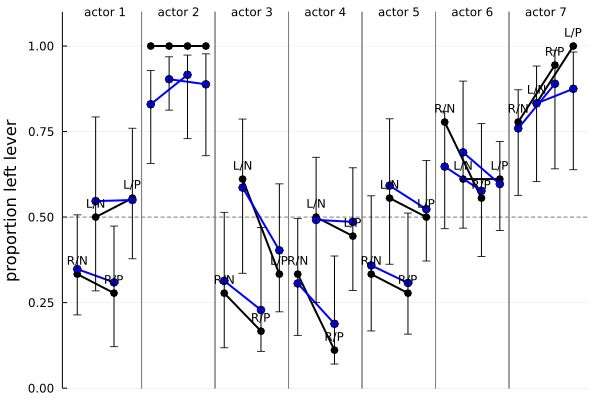

In [25]:
n_names = ["R/N", "L/N", "R/P", "L/P"]
p = plot(ylims=(0, 1.1), ylab="proportion left lever", showaxis=:y, xticks=false)
hline!([0.5], c=:gray, s=:dash)

# raw data
for actor in 1:7
    ofs = (actor-1)*4
    actor > 1 && vline!([ofs+0.5], c=:gray)
    plot!([ofs+1,ofs+3], collect(pl[actor,["1","3"]]), lw=2, m=:o, c=:black)
    plot!([ofs+2,ofs+4], collect(pl[actor,["2","4"]]), lw=2, m=:o, c=:black)
    anns = [
        (ofs+idx, pl[actor,string(idx)]+.04, (name, 8))
        for (idx,name) ∈ enumerate(n_names)
    ]
    actor != 2 && annotate!(anns)
end

annotate!([
    (2.5 + (idx-1)*4, 1.1, ("actor $idx", 8))
    for idx ∈ 1:7
])

# posterior predictions
for actor in 1:7
    ofs = (actor-1)*4
    actor > 1 && vline!([ofs+0.5], c=:gray)
    err = [rel_ci[actor,1], rel_ci[actor,3]]
    plot!([ofs+1,ofs+3], collect(p_μ[actor,[1,3]]), err=err, lw=2, m=:o, c=:blue)
    err = [rel_ci[actor,2], rel_ci[actor,4]]    
    plot!([ofs+2,ofs+4], collect(p_μ[actor,[2,4]]), err=err, lw=2, m=:o, c=:blue)
end

p

# 14.3 Instruments and causal designs

Code 14.23

In [26]:
Random.seed!(73)
N = 500
U_sim = rand(Normal(), N)
Q_sim = rand(1:4, N)
E_sim = [rand(Normal(μ)) for μ ∈ U_sim .+ Q_sim]
W_sim = [rand(Normal(μ)) for μ ∈ U_sim .+ 0*Q_sim]

dat_sim = DataFrame(
    W=standardize(ZScoreTransform, W_sim),
    E=standardize(ZScoreTransform, E_sim),
    Q=standardize(ZScoreTransform, float.(Q_sim)),
);

Code 14.24

In [27]:
@model function m14_4(W, E)
    σ ~ Exponential()
    aW ~ Normal(0, 0.2)
    bEW ~ Normal(0, 0.5)
    μ = @. aW + bEW * E
    W ~ MvNormal(μ, σ)
end

m14_4_ch = sample(m14_4(dat_sim.W, dat_sim.E),
    NUTS(), 1000)
m14_4_df = DataFrame(m14_4_ch)
precis(m14_4_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%   histogram │
├───────┼───────────────────────────────────────────────────────┤
│    aW │ -0.0016  0.0411  -0.0667  -0.0015  0.0635      ▁▃██▂▁ │
│   bEW │  0.3601  0.0421   0.2954   0.3605   0.427      ▁▂▆█▄▁ │
│     σ │  0.9345  0.0288    0.891   0.9354  0.9795  ▁▁▄▇██▅▂▁▁ │
└───────┴───────────────────────────────────────────────────────┘


Code 14.25

In [28]:
@model function m14_5(W, E, Q)
    σ ~ Exponential()
    aW ~ Normal(0, 0.2)
    bEW ~ Normal(0, 0.5)
    bQW ~ Normal(0, 0.5)
    μ = @. aW + bEW * E + bQW * Q
    W ~ MvNormal(μ, σ)
end

m14_5_ch = sample(m14_5(dat_sim.W, dat_sim.E, dat_sim.Q),
    NUTS(), 1000)
m14_5_df = DataFrame(m14_5_ch)
precis(m14_5_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%   histogram │
├───────┼───────────────────────────────────────────────────────┤
│    aW │ -0.0004  0.0401  -0.0618  -0.0003  0.0641     ▁▂██▃▁▁ │
│   bEW │  0.6029  0.0478   0.5269   0.6017  0.6825     ▁▃██▃▁▁ │
│   bQW │ -0.3803  0.0494  -0.4575  -0.3819  -0.302     ▁▂▆█▅▁▁ │
│     σ │  0.8871  0.0273   0.8449    0.886  0.9318  ▁▁▄▇█▅▃▁▁▁ │
└───────┴───────────────────────────────────────────────────────┘


Code 14.26

In [ ]:
@model function m14_6(W, E, Q, WE)
    σ ~ filldist(Exponential(), 2)
    ρ ~ LKJ(2, 2)
    aW ~ Normal(0, 0.2)
    aE ~ Normal(0, 0.2)
    bEW ~ Normal(0, 0.5)
    bQE ~ Normal(0, 0.5)
    μW = @. aW + bEW*E
    μE = @. aW + bQE*Q
    Σ = (σ .* σ') .* ρ
    for i ∈ eachindex(WE)
        WE[i] ~ MvNormal([μW[i], μE[i]], Σ)
    end
end

Random.seed!(1)

# need to combine W and E here (Turing vars limitation)
WE = [[w,e] for (w,e) ∈ zip(dat_sim.W, dat_sim.E)]

m14_6_ch = sample(m14_6(dat_sim.W, dat_sim.E, dat_sim.Q, WE), NUTS(200, 0.65, init_ϵ=0.003), 1000)
m14_6_df = DataFrame(m14_6_ch);

In [ ]:
# Drop cols with zero variance
df = m14_6_df[:,Not("ρ[1,1]")][:,Not("ρ[2,2]")]
precis(df)

Code 14.28

In [ ]:
Random.seed!(73)

N = 500
U_sim = rand(Normal(), N)
Q_sim = rand(1:4, N)
E_sim = [rand(Normal(μ)) for μ ∈ U_sim .+ Q_sim]
W_sim = [rand(Normal(μ)) for μ ∈ -U_sim .+ 0.2*Q_sim]

dat_sim = DataFrame(
    W=standardize(ZScoreTransform, W_sim),
    E=standardize(ZScoreTransform, E_sim),
    Q=standardize(ZScoreTransform, float.(Q_sim)),
);

Code 14.29

In [ ]:
using Dagitty

g = DAG(:Q => :E, :U => :E, :E => :W, :E => :W)
# not implemented in dagitty.jl yet

# 14.4 Social relations as correlated varying effects

Code 14.30

In [34]:
kl_dyads = DataFrame(CSV.File("data/KosterLeckie.csv"))
describe(kl_dyads)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,hidA,8.66667,1,8.0,24,0,Int64
2,hidB,17.3333,2,18.0,25,0,Int64
3,did,150.5,1,150.5,300,0,Int64
4,giftsAB,3.86667,0,1.0,75,0,Int64
5,giftsBA,5.70333,0,2.0,110,0,Int64
6,offset,-0.12636,-1.236,-0.022,0.0,0,Float64
7,drel1,0.0633333,0,0.0,1,0,Int64
8,drel2,0.12,0,0.0,1,0,Int64
9,drel3,0.213333,0,0.0,1,0,Int64


Code 14.31

In [35]:
kl_data = (
    N = nrow(kl_dyads), 
    N_households = maximum(kl_dyads.hidB),
    did = kl_dyads.did,
    hidA = kl_dyads.hidA,
    hidB = kl_dyads.hidB,
    giftsAB = kl_dyads.giftsAB,
    giftsBA = kl_dyads.giftsBA,
)

@model function m14_7(N, N_households, hidA, hidB, did, giftsAB, giftsBA)
    a ~ Normal()
    ρ_gr ~ LKJ(2, 4)
    σ_gr ~ filldist(Exponential(), 2)
    Σ = (σ_gr .* σ_gr') .* ρ_gr
    gr ~ filldist(MvNormal(Σ), N_households)
    
    # dyad effects (use 2 z values)
    z₁ ~ filldist(Normal(), N)
    z₂ ~ filldist(Normal(), N)
    z = [z₁ z₂]'
    σ_d ~ Exponential()
    ρ_d ~ LKJ(2, 8)
    L_ρ_d = cholesky(Symmetric(ρ_d)).L
    d = (σ_d .* L_ρ_d) * z

    λ_AB = exp.(a .+ gr[1, hidA] .+ gr[2, hidB] .+ d[1, did])
    λ_BA = exp.(a .+ gr[1, hidB] .+ gr[2, hidA] .+ d[2, did])
    for i ∈ eachindex(giftsAB)
        giftsAB[i] ~ Poisson(λ_AB[i])
        giftsBA[i] ~ Poisson(λ_BA[i])
    end
    return d
end

model = m14_7(
    kl_data.N, kl_data.N_households, kl_data.hidA, kl_data.hidB, 
    kl_data.did, kl_data.giftsAB, kl_data.giftsBA
)
m14_7_ch = sample(model, 
    NUTS(1000, 0.65, init_ϵ=0.025), 
    1000)
m14_7_df = DataFrame(m14_7_ch);

Code 14.32

In [36]:
precis(m14_7_df[:, r"_gr\[(1,2|2,1|1|2)\]"])

┌───────────┬──────────────────────────────────────────────────────────┐
│     param │    mean     std     5.5%      50%    94.5%     histogram │
├───────────┼──────────────────────────────────────────────────────────┤
│ ρ_gr[1,2] │ -0.4127  0.2038  -0.7163  -0.4299  -0.0465  ▁▃▆███▆▃▂▂▁▁ │
│ ρ_gr[2,1] │ -0.4127  0.2038  -0.7163  -0.4299  -0.0465  ▁▃▆███▆▃▂▂▁▁ │
│   σ_gr[1] │  0.8275   0.132   0.6357   0.8152   1.0527      ▁▅██▅▃▁▁ │
│   σ_gr[2] │  0.4209  0.0927   0.2867   0.4122   0.5823     ▁▂██▄▁▁▁▁ │
└───────────┴──────────────────────────────────────────────────────────┘


Code 14.33

In [37]:
g = [
    m14_7_df.a .+ m14_7_df[!,"gr[1,$i]"]
    for i ∈ 1:25
]
r = [
    m14_7_df.a .+ m14_7_df[!,"gr[2,$i]"]
    for i ∈ 1:25
]
g = hcat(g...)'
r = hcat(r...)';
Eg_μ = mean(eachcol(exp.(g)))
Er_μ = mean(eachcol(exp.(r)));

Code 14.34

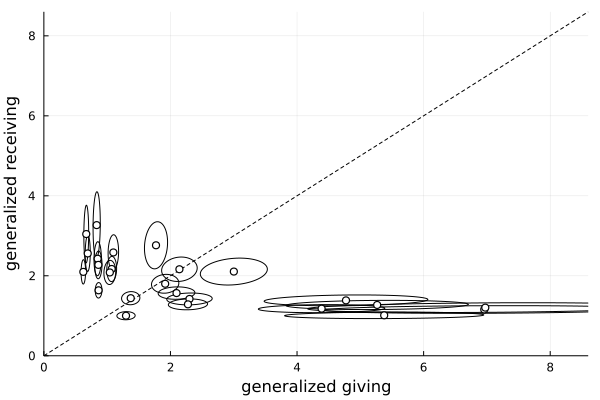

In [38]:
plot(xlim=(0, 8.6), ylim=(0,8.6), xlab="generalized giving", ylab="generalized receiving")
plot!(x -> x, c=:black, s=:dash)

for i ∈ 1:25
    gi = exp.(g[i,:])
    ri = exp.(r[i,:])
    Σ = cov([gi ri])
    μ = [mean(gi), mean(ri)]

    dt = acos(Σ[1,2])
    xₜ(t) = Σ[1,1]*cos(t + dt/2) + μ[1]
    yₜ(t) = Σ[2,2]*cos(t - dt/2) + μ[2]

    plot!(xₜ, yₜ, 0, 2π, c=:black, lw=1)
end

scatter!(Eg_μ, Er_μ, c=:white, msw=1.5)

Code 14.35

In [39]:
precis(m14_7_df[:, r"_d"])

┌──────────┬──────────────────────────────────────────────────────┐
│    param │   mean     std    5.5%     50%   94.5%     histogram │
├──────────┼──────────────────────────────────────────────────────┤
│ ρ_d[1,1] │    1.0     0.0     1.0     1.0     1.0             █ │
│ ρ_d[1,2] │  0.879  0.0358  0.8176  0.8819  0.9301  ▁▁▁▁▂▃▅███▄▁ │
│ ρ_d[2,1] │  0.879  0.0358  0.8176  0.8819  0.9301  ▁▁▁▁▂▃▅███▄▁ │
│ ρ_d[2,2] │    1.0     0.0     1.0     1.0     1.0             █ │
│      σ_d │ 1.1021  0.0595  1.0143  1.1006  1.1986     ▁▁▅██▅▂▁▁ │
└──────────┴──────────────────────────────────────────────────────┘


Code 14.36

Illustrates `generated_quantities` trick to extract values returned from the model

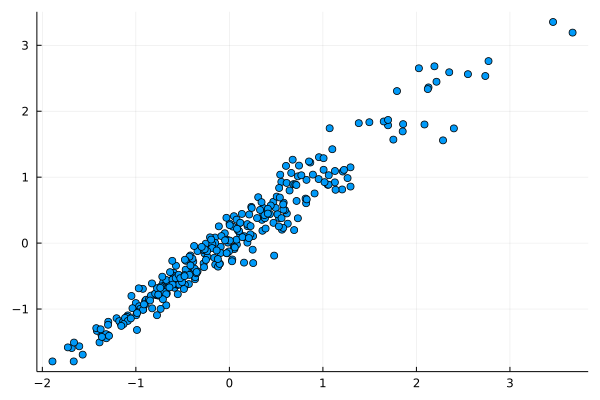

In [41]:
ch = Turing.MCMCChains.get_sections(m14_7_ch, :parameters)
d_vals = generated_quantities(model, ch)

d_y1 = [r[1,:] for r in d_vals]
d_y1 = hcat(d_y1...)
d_y1 = mean.(eachrow(d_y1))

d_y2 = [r[2,:] for r in d_vals]
d_y2 = hcat(d_y2...)
d_y2 = mean.(eachrow(d_y2))

scatter(d_y1, d_y2)

# 14.5 Continuous categories and the Gaussian process

Code 14.37

In [43]:
islandsDistMatrix = DataFrame(CSV.File("data/islandsDistMatrix.csv"))
# drop index column
select!(islandsDistMatrix, Not(:Column1))

# round distances
show(mapcols(c -> round.(c, digits=1), islandsDistMatrix), allcols=true)

10×10 DataFrame
 Row │ Malekula  Tikopia  Santa Cruz  Yap      Lau Fiji  Trobriand  Chuuk    Manus    Tonga    Hawaii  
     │ Float64   Float64  Float64     Float64  Float64   Float64    Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────
   1 │      0.0      0.5         0.6      4.4       1.2        2.0      3.2      2.8      1.9      5.7
   2 │      0.5      0.0         0.3      4.2       1.2        2.0      2.9      2.7      2.0      5.3
   3 │      0.6      0.3         0.0      3.9       1.6        1.7      2.6      2.4      2.3      5.4
   4 │      4.4      4.2         3.9      0.0       5.4        2.5      1.6      1.6      6.1      7.2
   5 │      1.2      1.2         1.6      5.4       0.0        3.2      4.0      3.9      0.8      4.9
   6 │      2.0      2.0         1.7      2.5       3.2        0.0      1.8      0.8      3.9      6.7
   7 │      3.2      2.9         2.6      1.6       4.

Code 14.38

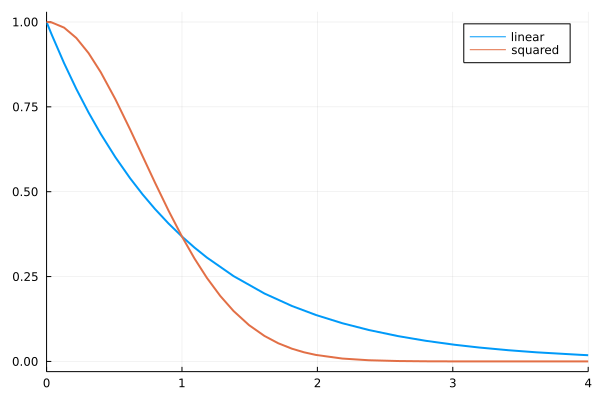

In [44]:
plot(x -> exp(-x), xlim=(0, 4), label="linear", lw=2)
plot!(x -> exp(-(x^2)), label="squared", lw=2)

Code 14.39

Adapted from example here:
https://discourse.julialang.org/t/gaussian-process-model-with-turing/42453

In [46]:
d = DataFrame(CSV.File("data/Kline2.csv"))
d[:, "society"] = 1:10;

dat_list = (
    T = d.total_tools,
    P = d.population,
    society = d.society,
    Dmat = Matrix(islandsDistMatrix),
)

@model function m14_8(T, P, society, Dmat)
    η² ~ Exponential(2)
    ρ² ~ Exponential(0.5)
    a ~ Exponential()
    b ~ Exponential()
    g ~ Exponential()
    
    Σ = η² * exp.(-ρ² * Dmat^2) + LinearAlgebra.I * (0.01 + η²)
    k ~ MvNormal(zeros(10), Σ)
    λ = @. (a*P^b/g)*exp(k[society])
    @. T ~ Poisson(λ)
end

Random.seed!(1)
m14_8_ch = sample(m14_8(dat_list.T, dat_list.P, dat_list.society, dat_list.Dmat), 
    NUTS(), 1000)
m14_8_df = DataFrame(m14_8_ch);

Code 14.40

In [47]:
precis(m14_8_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │  1.3729  1.0277   0.2465   1.1349  3.2976     █▇▃▁▁▁▁▁ │
│     b │  0.2903   0.077   0.1748    0.286  0.4153  ▁▁▃▆█▇▄▂▁▁▁ │
│     g │  0.6503  0.5602   0.0963   0.4919  1.7434     █▅▂▁▁▁▁▁ │
│ k[10] │ -0.1759  0.3188  -0.6916  -0.1584  0.2592      ▁▁▂█▄▁▁ │
│  k[1] │ -0.1962  0.2674  -0.6053  -0.2005  0.2264  ▁▁▁▁▄██▄▂▁▁ │
│  k[2] │  0.1014  0.2338  -0.2778   0.0937  0.4808    ▁▃▆█▆▂▁▁▁ │
│  k[3] │ -0.0192  0.2194  -0.3551  -0.0199  0.3188    ▁▁▁▄██▃▁▁ │
│  k[4] │  0.3879  0.2104   0.0751    0.372  0.7399     ▁▄█▇▂▁▁▁ │
│  k[5] │   0.067  0.2089  -0.2548   0.0594  0.3888     ▁▂▆█▅▁▁▁ │
│  k[6] │ -0.3445  0.2373   -0.732  -0.3297  0.0003     ▁▁▃▇█▆▂▁ │
│  k[7] │  0.1702    0.21  -0.1512   0.1695  0.4766    ▁▁▄█▇▂▁▁▁ │
│  k[8] │ -0.1921   0.221  -0.5543  -0.1774  0.1498    ▁▁▃▇█▃▁

Code 14.41

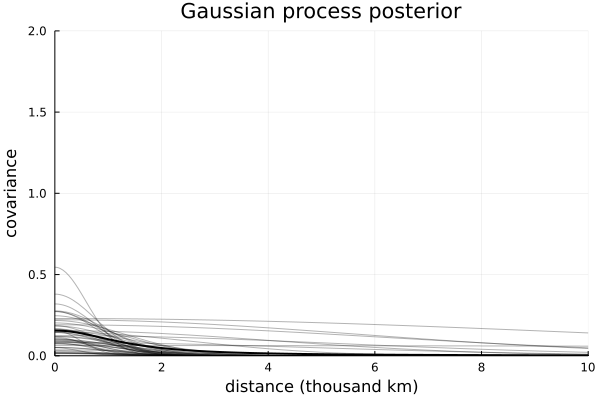

In [48]:
x_seq = range(0, 10, length=100)
rx_link = (r, x) -> r.η²*exp(-r.ρ²*x^2)
pmcov = link(m14_8_df, rx_link, x_seq)
pmcov = hcat(pmcov...)
pmcov_μ = mean.(eachcol(pmcov))

p = plot(xlab="distance (thousand km)", ylab="covariance", title="Gaussian process posterior",
    xlim=(0,10), ylim=(0,2))
plot!(x_seq, pmcov_μ, c=:black, lw=2)

for r ∈ first(eachrow(m14_8_df), 50)
    plot!(x -> rx_link(r, x), c=:black, alpha=0.3)
end

p

Code 14.42

In [49]:
η² = median(m14_8_df.η²)
ρ² = median(m14_8_df.ρ²)
K = map(d -> η² * exp(-ρ²*d^2), Matrix(islandsDistMatrix))
K += LinearAlgebra.I * (0.01 + η²);

Code 14.43

In [50]:
Rho = round.(cov2cor(K, sqrt.(diag(K))), digits=2)
cnames = ["Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha"]
Rho = DataFrame(Rho, :auto)
rename!(Rho, cnames)
show(Rho, allcols=true)

10×10 DataFrame
 Row │ Ml       Ti       SC       Ya       Fi       Tr       Ch       Mn       To       Ha      
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │    1.0      0.44     0.41     0.0      0.27     0.1      0.01     0.03     0.13      0.0
   2 │    0.44     1.0      0.46     0.0      0.27     0.11     0.02     0.03     0.11      0.0
   3 │    0.41     0.46     1.0      0.0      0.2      0.16     0.04     0.06     0.07      0.0
   4 │    0.0      0.0      0.0      1.0      0.0      0.05     0.19     0.18     0.0       0.0
   5 │    0.27     0.27     0.2      0.0      1.0      0.01     0.0      0.0      0.39      0.0
   6 │    0.1      0.11     0.16     0.05     0.01     1.0      0.14     0.37     0.0       0.0
   7 │    0.01     0.02     0.04     0.19     0.0      0.14     1.0      0.28     0.0       0.0
   8 │    0.03     0.

Code 14.44

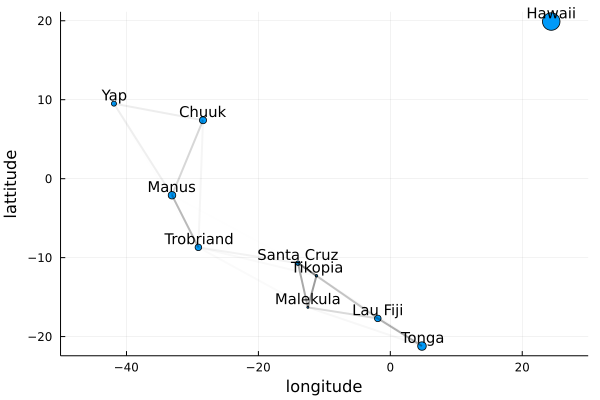

In [53]:
psize = d.logpop ./ maximum(d.logpop)
psize = @. exp(psize * 1.5) - 2

labels = map(s -> text(s, 10, :bottom), d.culture)
p = scatter(d.lon2, d.lat, msize=psize*4, texts=labels,
    xlab="longitude", ylab="lattitude", xlim=(-50, 30))
for (i, j) ∈ Base.Iterators.product(1:10, 1:10)
    i >= j && continue
    plot!(d.lon2[[i,j]], d.lat[[i, j]], c=:black, lw=2, alpha=2*(Rho[i,j]^2))
end
p

Code 14.45

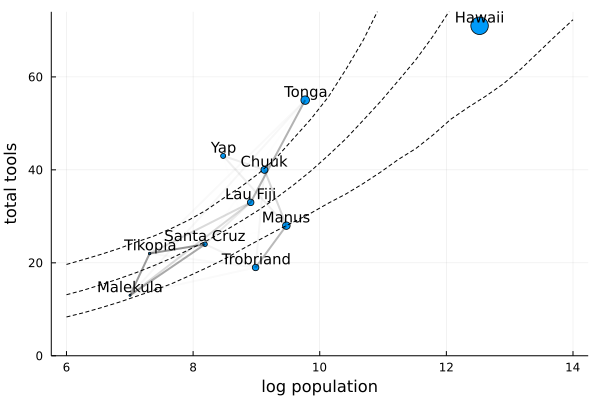

In [54]:
logpop_seq = range(6, 14, length=30)
rx_link = (r, x) -> r.a * exp(x)^r.b / r.g
λ = link(m14_8_df, rx_link, logpop_seq)
λ = hcat(λ...)
λ_median = median.(eachcol(λ))
λ_pi = PI.(eachcol(λ))
λ_pi = hcat(λ_pi...)'

p = scatter(d.logpop, d.total_tools, msize=psize*4, texts=labels, 
        xlab="log population", ylab="total tools", ylim=(0, 74))
plot!(logpop_seq, λ_median, c=:black, ls=:dash)
plot!(logpop_seq, λ_pi[:,1], c=:black, ls=:dash)
plot!(logpop_seq, λ_pi[:,2], c=:black, ls=:dash)

# overlay correlation
for (i, j) ∈ Base.Iterators.product(1:10, 1:10)
    i >= j && continue
    plot!(d.logpop[[i,j]], d.total_tools[[i, j]], c=:black, lw=2, alpha=2*(Rho[i,j]^2))
end
p

Code 14.46

In [55]:
@model function m14_8nc(T, P, society, Dmat)
    η² ~ Exponential(2)
    ρ² ~ Exponential(0.5)
    a ~ Exponential()
    b ~ Exponential()
    g ~ Exponential()
    
    Σ = η² * exp.(-ρ² * Dmat^2) + LinearAlgebra.I * (0.01 + η²)
    L_Σ = cholesky(Σ).L
    z ~ filldist(Normal(0, 1), 10)
    k = L_Σ .* z 
    λ = @. (a*P^b/g)*exp(k[society])
    @. T ~ Poisson(λ)
end

Random.seed!(1)
m14_8nc_ch = sample(m14_8nc(dat_list.T, dat_list.P, dat_list.society, dat_list.Dmat), 
    NUTS(), 1000);